Had to install latest version to work around this issue: https://forums.fast.ai/t/poor-results-when-running-chapter-5-examples/87161

In [1]:
!pip install git+https://github.com/fastai/fastai/ &>/dev/null

In [2]:
from fastai.vision.all import *

In [3]:
import fastai
print(fastai.__version__)

2.4.2


In [4]:
path = untar_data(URLs.PETS)
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/"images")

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [5]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
learner = learn.load('/kaggle/input/lesson-4/models/pet_breeds_l4')

## 00:00:00 - Lesson 4 review

* Ensure you understand Cross Entropy loss before continuing on.

## 00:01:09 - Model interpretation

* A confusion matrix: displays the correct predictions in the diagonal.

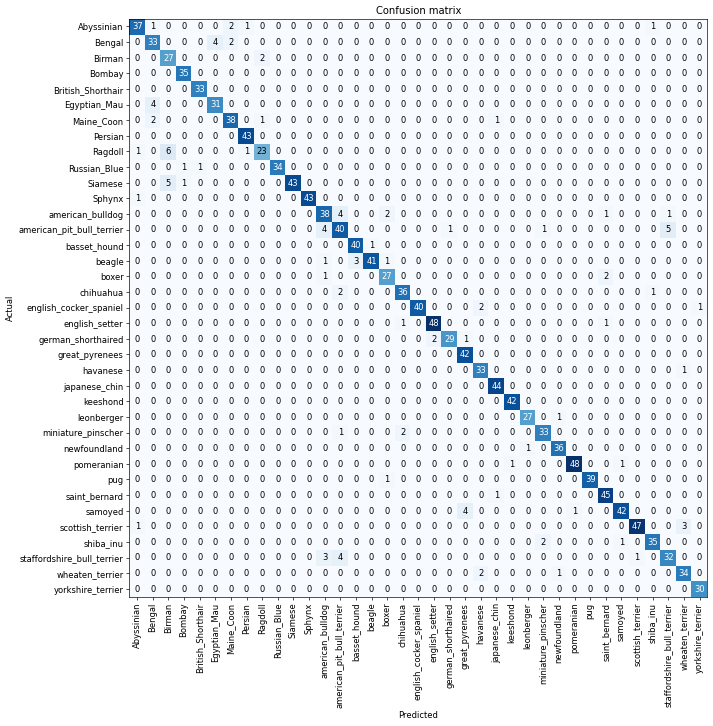

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

* When you have a lot of classes, it can be better to use `most_confused`
  * Tells you combinations that it had most trouble with.

In [8]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 6),
 ('Siamese', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]

* Even experts don't agree about Birman and Ragdoll
  * When model makes sensible mistakes, it's a good sign.

## 00:03:09 - Improving learning rate to train a better model

* One way to make model better is to improve learning rate.
* Bigger learning rate = faster training.
  * However, too might and the model will overstep the minimum.

## 00:05:00 - Learning Rate Finder

* [[Learning Rate Finder]]
  * Idea by Leslie Smith:
    * Start with tiny learning rate.
    * Take a minibatch and step, then record the losses.
    * Increase learning rate by some %.
    * Step again.
    * Keep doing until loss gets worse.
    * Select learning rate a bit before you go to far.
    * Pick either:
      * One order of magnitude less (the min divided by 10).
      * Loss point where loss was decreasing.
 * `lr_find()` in fastai computes that for you.

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0010000000474974513)

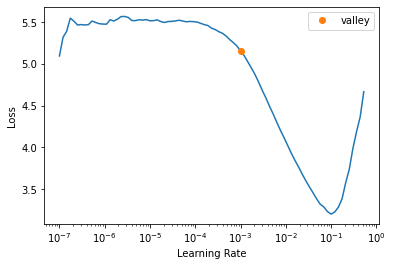

In [9]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

* You can then retrain using recommended epoch.

In [10]:
learn.fine_tune(2, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.063722,0.389853,0.120433,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.577278,0.273993,0.082544,01:09
1,0.376261,0.234854,0.077131,01:09


* Learning rate finder was only discovered in 2015.
  * Shows how many more discoveries in DL.
  * People in engineering tend to prefer this completely automated.

## 00:09:34 - Question: Is the learning rate plotter plotted against a single mini-batch?

* It's plotted while walking through the DataLoader, as you normally would when training.

## 00:10:13 - Question: Is network reset after each mini-batch, or does it accumulate?

* It's not reset. We want to see it improving.
* At end of training, we go back to previous rates.

## 00:10:53 - Question: why would a single learning rate found at the start of training, still be useful after many epochs?

* Next section.

## 00:11:17 - Question: for the learning rate finder, why use the steepest and not minimum?

* The minimum is the point where it's no longer learning.
* We want somewhere before:
  * Sylvan's favourite approach: minimum / 10.

## 00:12:09 - Transfer learning recap

* Firstly, neural network is a bunch of linear layers with activation functions between them.
* Each linear layers have parameters.
* After you train neural network on image net, have parameters that aren't random.
* Early layers learn about general ideas and later are more specfic.
* Transfer learning:
  * Take parameters that have been trained.
  * Get rid of very last layer and replace with random weights.
  * Freeze the other layers, and just train the last layer.
  
## 00:13:50 - Learning rate finder simplicity

* Seems surprising that the learner rate finder can be so useful even though so simple and approximate.
* Wasn't really know until fastai started talking about it.

## 00:15:37 - Transer learning continued

* `fine_tune` is the method fastai uses to do it. 

In [11]:
learn.fine_tune??

* Freeze everything up to the last layer: `self.freeze()`
* Then just fit the randomly added weights.
* Unfreeze all the other layers.
* Fit for some number of epochs.

## 00:18:13 - Fine tune by "hand"

* We don't have to use `fine_tune`:

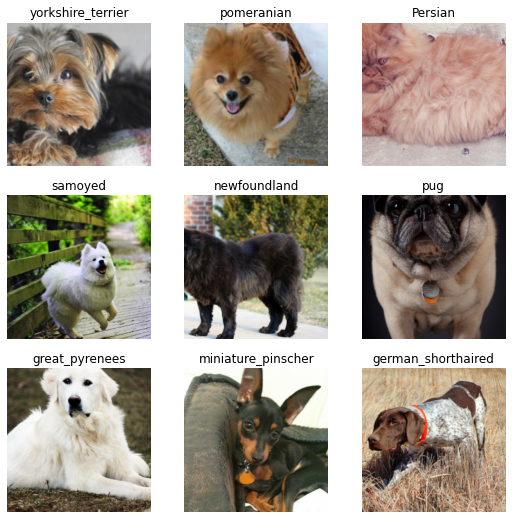

In [12]:
dls.show_batch()

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0014454397605732083)

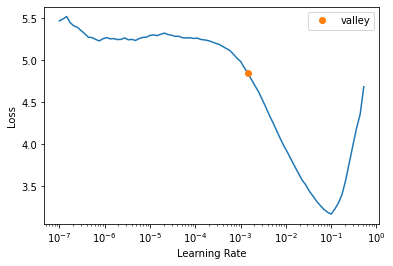

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.122182,0.327917,0.113667,01:08
1,0.540056,0.241719,0.086604,01:06
2,0.338942,0.215674,0.073748,01:07


* `cnn_learner` already freezes the model for you.

* Then we can manually unfreeze the model:

In [16]:
learn.unfreeze()

## 00:18:45 - running lr_find after unfreezing

* You would assume it would be the wrong learning rate, so we can run lr_find again.

## 

SuggestedLRs(valley=9.120108734350652e-05)

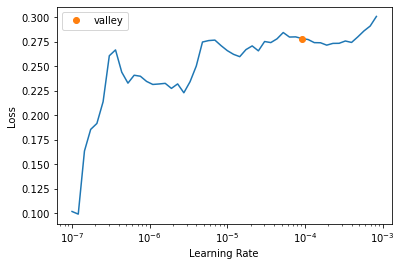

In [17]:
learn.lr_find()

* The shape here is different because the model is trained.
  * We generally take the point where it starts to get worse. Like 10-4 and divide by 10 back from that.

In [18]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.251161,0.205250,0.070365,01:09
1,0.251269,0.201598,0.068336,01:09
2,0.218967,0.196250,0.066982,01:09
3,0.194220,0.191418,0.060893,01:09
4,0.181446,0.192967,0.062246,01:09
5,0.182578,0.191706,0.064953,01:09


## 00:19:32 - Discriminative learning rates



* Since we know later layers are more specific to the problem, and the earlier general.
  * Want bigger learning rate for the later layers and smaller for earlier.
  * Originally developed in ULMFiT
    * Based on paper by Jason Yosinski who showed that layers should train at different speeds (though he didn't actually run the experiment)
* Fastai lets you pass `slice` object
  * Slice is an object
  * Very first layer will be 1e-6 and the last will be 1e-4
    * Learning rates in between will be equally sliced.

In [19]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.148988,0.391744,0.122463,01:08
1,0.516430,0.264915,0.085250,01:07
2,0.336015,0.221417,0.064953,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.264971,0.219408,0.069012,01:09
1,0.246522,0.208800,0.063599,01:10
2,0.228430,0.203198,0.064276,01:09
3,0.200924,0.199840,0.060893,01:09
4,0.167146,0.203511,0.062246,01:08
5,0.160588,0.194302,0.058863,01:09
6,0.157753,0.203722,0.062923,01:08
7,0.146432,0.198053,0.062246,01:08
8,0.128020,0.198028,0.060217,01:08
9,0.122255,0.197612,0.058187,01:09


## 00:22:06 - fit_one_cycle

* Starts at a low learning rate
* increases it gradually for first 1/3 until it gets to `lr_max`
* Then remaining 2/3, it gradually decreases.
* Developed by Leslie Smith (same person who did learning rate finder).
  * Ignored by academic community.
* Looking at results above, we don't necessarily just want to take model with lowest weights.
  * We'd like to train model again with number of epochs equal to the best error rate.
  * Change epochs 12 to 8 and train from scratch.

## 00:22:56 - Plot loss

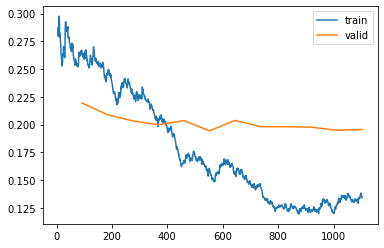

In [20]:
learn.recorder.plot_loss()

* Often see validation loss get worse before error rate gets worse.

## 00:24:40 - Improving model with deeper architectures and fp16

* Could try creating a deeper architecture: more pairs of linear layers and activation functions.
  * For pretrained models, there's usually a small section of layer numbers available: `resnet18`, `resnet34`, `resnet50` etc.
* Bigger models have more parameters and more gradients.
  * It's common to run out of GPU memory: `Cuda runtime error: out of memory`.
    * If it happens, restart notebook and try again with smaller learning rate.
* Can add `fp_16()` to use less precise numbers (half precision floating point, also called fp16).

In [21]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6, 1e-4))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.803505,0.371108,0.117050,01:12
1,0.433064,0.254045,0.069689,01:11
2,0.244331,0.209135,0.063599,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.178246,0.194852,0.060217,01:14
1,0.173872,0.186954,0.055480,01:14
2,0.146353,0.177561,0.052774,01:14
3,0.134664,0.181752,0.057510,01:15
4,0.104747,0.177655,0.060217,01:14
5,0.104844,0.176375,0.057510,01:14
6,0.102450,0.172244,0.054804,01:15
7,0.085970,0.173649,0.056834,01:14


* Trick is to use small models for as long as possible, to clean data and get pipeline ready etc.

## 00:28:36 - Question: how do you know or suspect that you can do better?

* Always assume you can do better, because you never know.
* Ask yourself: do you need to do better? Will model be useful enough now?
  * Do something practical with model as soon as possible.

## 00:29:41 - Questionaire and further research

* Read paper by Leslie Smith that introduced the learning rate finder.
* Try to improve accuracy in chapter.

## 00:30:48 - Multi-label classification

Continued in next notebook.